# АНСАМБЛИ МОДЕЛЕЙ

In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tqdm
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#устраним ошибки со шрифтами
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']

# Часть 1. Бэггинг

## Описание задачи

Используем данные страхового подразделения BNP Paribas из соревнования

https://www.kaggle.com/c/bnp-paribas-cardif-claims-management

Решается задача классификации страховых случаев:
    1. Случаи, требующие дополнительных документов для подтвердения (0)
    2. Случаи, которые можно подтверждать автоматически на основе имеющейся информации (1)

## Загрузка данных

In [65]:
data = pd.read_csv('datasets/ensembles/train.csv')

data.head()

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN


Уменьшим размер данных для ускорения обучения, возмем случайную подвыборку 20% данных со стратификацией

In [66]:
from sklearn.model_selection import StratifiedShuffleSplit

random_splitter = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=777)

for train_index, test_index in random_splitter.split(data, data.target):
    data = data.iloc[test_index]

Разбиение на обучение и hold-out тест 70/30. Данных досттаточно много, поэтому можно принебречь честной кросс-валидацией и оценивать модель
на тесте

In [67]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=.3, random_state=777)

for train_index, test_index in splitter.split(data, data.target):
    d_train = data.iloc[train_index]
    d_test = data.iloc[test_index]
    
    y_train = data['target'].iloc[train_index]
    y_test = data['target'].iloc[test_index]

## Первичный анализ

Размер датасета

In [68]:
data.shape

(22865, 133)

Распределение значений таргета (event rate)

In [69]:
data.target.value_counts()/len(data)

1    0.761207
0    0.238793
Name: target, dtype: float64

## Предобработка данных

Находим категориальные признаки

Чтобы в разы не увеличивать число признаков при построении dummi, будем использовать категориальные
признаки с < 30 уникальных значений

In [70]:
data.dtypes.head(50)

ID          int64
target      int64
v1        float64
v2        float64
v3         object
v4        float64
v5        float64
v6        float64
v7        float64
v8        float64
v9        float64
v10       float64
v11       float64
v12       float64
v13       float64
v14       float64
v15       float64
v16       float64
v17       float64
v18       float64
v19       float64
v20       float64
v21       float64
v22        object
v23       float64
v24        object
v25       float64
v26       float64
v27       float64
v28       float64
v29       float64
v30        object
v31        object
v32       float64
v33       float64
v34       float64
v35       float64
v36       float64
v37       float64
v38         int64
v39       float64
v40       float64
v41       float64
v42       float64
v43       float64
v44       float64
v45       float64
v46       float64
v47        object
v48       float64
dtype: object

In [71]:
cat_feat = list(data.dtypes[data.dtypes == object].index)

# закодируем пропущенные знаения строкой, факт пропущенного значения тоже может нести в себе информацию
data[cat_feat] = data[cat_feat].fillna('nan')

# отфильтруем непрерывные признаки
num_feat = [f for f in data if f not in (cat_feat + ['ID', 'target'])]

cat_nunique = d_train[cat_feat].nunique()
print(cat_nunique)
cat_feat = list(cat_nunique[cat_nunique < 30].index)

v3         3
v22     6610
v24        5
v30        7
v31        3
v47        9
v52       12
v56       90
v66        3
v71        5
v74        3
v75        4
v79       17
v91        7
v107       7
v110       3
v112      22
v113      34
v125      88
dtype: int64


In [72]:
from sklearn.metrics import auc, roc_curve
from sklearn.linear_model import LogisticRegression

## Композиция моделей одного семейства

### Будем использовать решеющие деревья

1. Неустойчивы к входным данным
2. Склонны к переобучению
3. Быстро обучаются

=> отличный выбор для построения композиций

**Создаем признаки для "деревянных" моделей**

1. Заменяем пропуски на специальны значения -999, чтобы деревья могли их отличить
2. Создаем дамми-переменный для категорий

In [73]:
dummi_train = pd.get_dummies(d_train[cat_feat], columns=cat_feat)
dummi_test = pd.get_dummies(d_test[cat_feat], columns=cat_feat)

dummi_cols = list(set(dummi_train) & set(dummi_test))

dummi_train = dummi_train[dummi_cols]
dummi_test = dummi_test[dummi_cols]

X_train = pd.concat([d_train[num_feat].fillna(-999), dummi_train], axis=1)

X_test = pd.concat([d_test[num_feat].fillna(-999), dummi_test], axis=1)

Обучаем решающее дерево

Немного ограничим глубину и минимальное количество объектов в листе для уменьшения переобучения

In [74]:
dummy_train = pd.get_dummies(d_train[cat_feat], columns=cat_feat)
dummy_test = pd.get_dummies(d_test[cat_feat], columns=cat_feat)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]


X_train = pd.concat([d_train[num_feat].fillna(-999),
                     dummy_train], axis=1)

X_test = pd.concat([d_test[num_feat].fillna(-999),
                     dummy_test], axis=1)

In [75]:
from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier(max_depth=15, min_samples_leaf=20)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=15, min_samples_leaf=20)

#### Считаем ROS AUC

In [76]:
def calc_auc(y, y_pred, plot_label='', prin=True):
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print(f'ROC AUC: {auc_val:.4f}')
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

Предсказываем  вероятность класса 1 и считаем ROC AUC

Train
ROC AUC: 0.8589
Test
ROC AUC: 0.6477


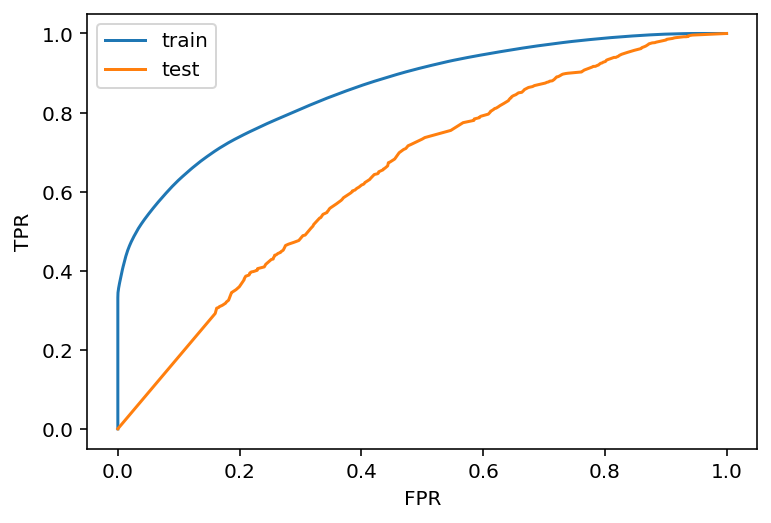

In [77]:
y_pred_test = clf_tree.predict_proba(X_test)[:, 1]
y_pred_train = clf_tree.predict_proba(X_train)[:, 1]

print('Train')
calc_auc(y_train, y_pred_train, 'train')
print('Test')
calc_auc(y_test, y_pred_test, 'test')
plt.legend();

### Бэггинг

In [78]:
import numpy as np

In [79]:
np.arange(y_train.shape[0])

array([    0,     1,     2, ..., 16002, 16003, 16004])

In [80]:
BAGGING_ITERS = 20

y_pred_test = np.zeros_like(y_pred_test)
y_pred_train = np.zeros_like(y_pred_train)

for i in tqdm.trange(BAGGING_ITERS):
    new_index = np.random.choice(np.arange(y_train.shape[0]), size=y_train.shape[0], replace=True)
    clf_tree.fit(X_train.iloc[new_index], y_train.iloc[new_index])
    
    y_pred_test += clf_tree.predict_proba(X_test)[:, 1]
    y_pred_train += clf_tree.predict_proba(X_train)[:, 1]

y_pred_test /= BAGGING_ITERS
y_pred_train /= BAGGING_ITERS

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.62s/it]


Train
ROC AUC: 0.9197
Test
ROC AUC: 0.7111


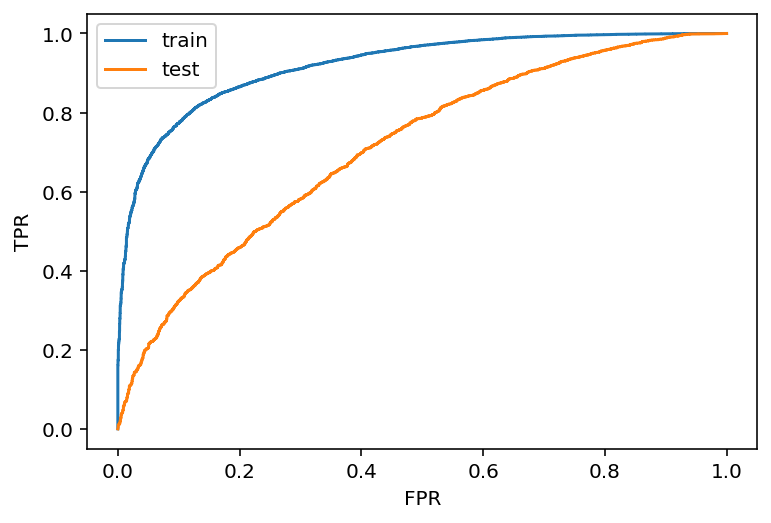

In [81]:
print('Train')
calc_auc(y_train, y_pred_train, 'train')
print('Test')
calc_auc(y_test, y_pred_test, 'test')
plt.legend();

### Бэггинг

Используем готовый алгоритм из sklearn

In [82]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(n_estimators=20, base_estimator=clf_tree, n_jobs=-1)

%time bag_clf.fit(X_train, y_train)

y_pred_test = bag_clf.predict_proba(X_test)[:, 1]
y_pred_train = bag_clf.predict_proba(X_train)[:, 1]

Wall time: 17.5 s


Train
ROC AUC: 0.8914
Test
ROC AUC: 0.7201


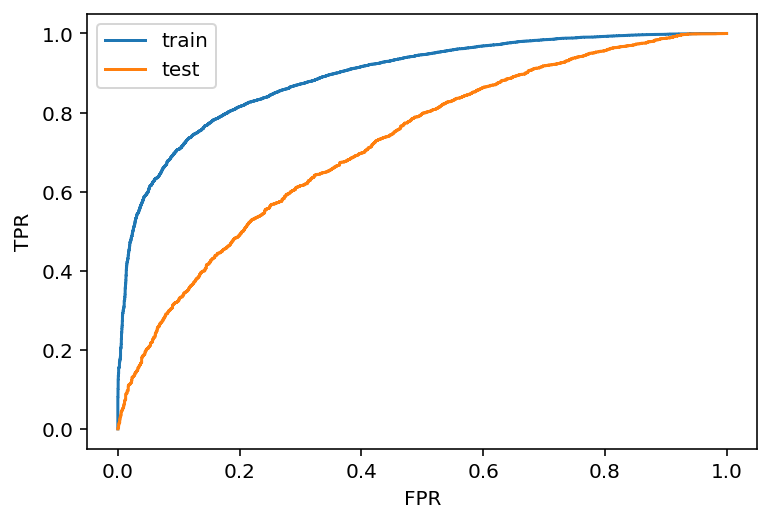

In [83]:
print('Train')
calc_auc(y_train, y_pred_train, 'train')
print('Test')
calc_auc(y_test, y_pred_test, 'test')
plt.legend();

# Часть 2. Случайный лес

Бэггинг + случайные подпространства = случайный лес

**Важные гиперпараметры алгоритма**

а. Параметры деревьев
    1. criterion - критерий построения дерева
    2. max_dept - максимальная глубина дерева(обычно 10-20, больше глубина -> больше риск переобучения)
    3. min_samples_leaf - минимальное число объектов в листе (обычно 20+, больше объектов -> меньше
                                                             риск переобучения)
b. Параметры леса
    1. n_estimators - количество деревьев (чем больше, тем лучше)
    2. max_features - число признаков случайного подпространства
    3. bootstrap - использовать ли бэггинг
    4. n_jobs - количество потоков для одновременного построения деревьев (большая прибавка к скорости на
                                                                           многоядерных процессарах)

In [84]:
'минимальное число объектов в листе'.upper()

'МИНИМАЛЬНОЕ ЧИСЛО ОБЪЕКТОВ В ЛИСТЕ'

In [85]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_leaf=20, max_features=.8, n_jobs=-1)

%time clf_rf.fit(X_train, y_train)

Wall time: 31.6 s


RandomForestClassifier(max_depth=15, max_features=0.8, min_samples_leaf=20,
                       n_estimators=300, n_jobs=-1)

Train
ROC AUC: 0.9013
Test
ROC AUC: 0.7267


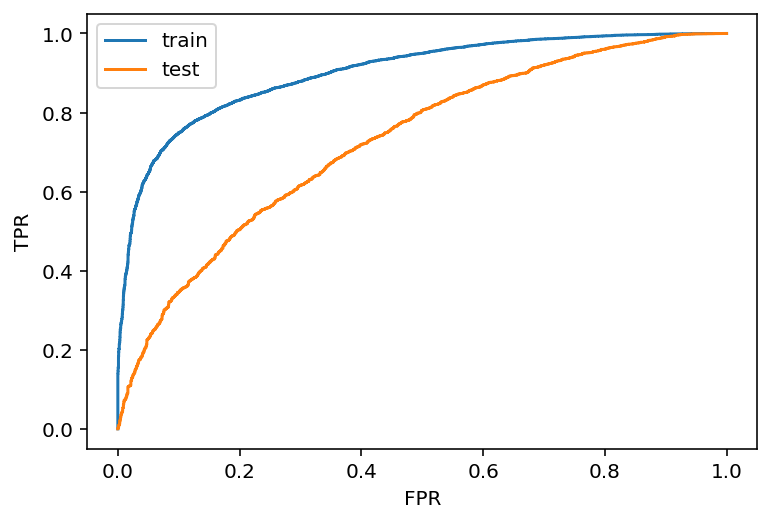

In [86]:
y_pred_rf_test = clf_rf.predict_proba(X_test)[:, 1]
y_pred_rf_train = clf_rf.predict_proba(X_train)[:, 1]

print('Train')
calc_auc(y_train, y_pred_rf_train, 'train')
print('Test')
calc_auc(y_test, y_pred_rf_test, 'test')
plt.legend();

#### Важность признаков

В sklearn - усредненное по всем деревьям в ансамбле колчество сплитов по признаку, взвешенное на прирост
информации (information gain) и долю объектов в вершине, в которой производится этот сплит

это не единственный вариант, см. здесь:

https://medium.com/@ceshine/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3

Важность признаков случайного леса лежат в атрибуте **feature\_importances\_**

In [87]:
imp = pd.Series(clf_rf.feature_importances_, X_train.columns)
imp.sort_values(ascending=False)

v50       0.271169
v66_C     0.039596
v21       0.034176
v12       0.030357
v110_A    0.029145
            ...   
v30_B     0.000000
v107_G    0.000000
v79_A     0.000000
v74_C     0.000000
v75_C     0.000000
Length: 219, dtype: float64

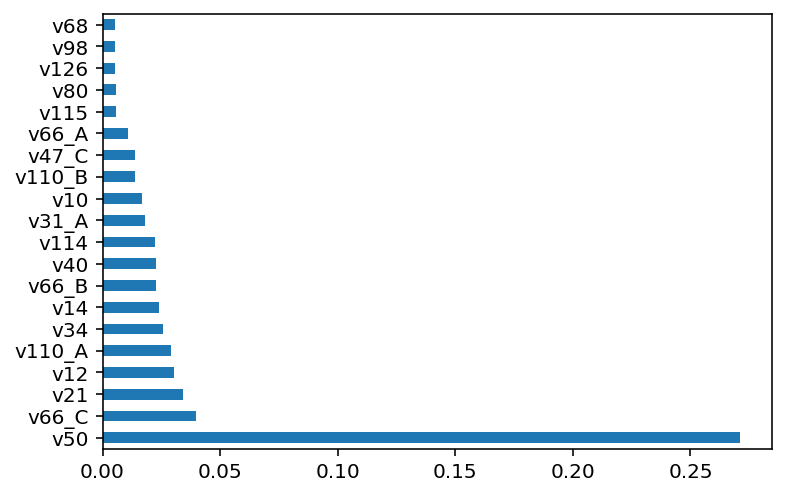

In [88]:
imp.sort_values(ascending=False).iloc[:20].plot(kind='barh');

# Часть 3. Композиции моделей разных типов

### Линейная комбинация моделей разного типа

Смешаем дерево и логистическую регрессию

**Создадим признаки для логистической регрессии**

1. Заменяем пропуски на медианы
2. Создаем индикаторы пропущенных значений
3. Создаём дамми-переменные для категорий

In [97]:
d_train[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN')

,v1_NaN,v2_NaN,v4_NaN,v5_NaN,v6_NaN,v7_NaN,v8_NaN,v9_NaN,v10_NaN,v11_NaN,...,v52_NaN,v66_NaN,v71_NaN,v74_NaN,v75_NaN,v79_NaN,v91_NaN,v107_NaN,v110_NaN,v112_NaN
17348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62337,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
113860,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84309,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100237,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24223,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7127,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
37765,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
77353,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
from sklearn.preprocessing import StandardScaler

train_median = d_train[num_feat].median()

X_train_lin = pd.concat([d_train[num_feat].fillna(train_median),
                       d_train[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                       dummy_train], axis=1)

X_test_lin = pd.concat([d_test[num_feat].fillna(train_median),
                       d_test[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                       dummy_test], axis=1)

scaler = StandardScaler()
scaler.fit(X_train_lin[num_feat])

X_train_lin[num_feat] = scaler.transform(X_train_lin[num_feat])
X_test_lin[num_feat] = scaler.transform(X_test_lin[num_feat])

Обучим логистическую регрессию

In [93]:
clf_lr = LogisticRegression(solver='liblinear', penalty='l1', C=.1)

clf_lr.fit(X_train_lin, y_train)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

Train
ROC AUC: 0.7324
Test
ROC AUC: 0.7240


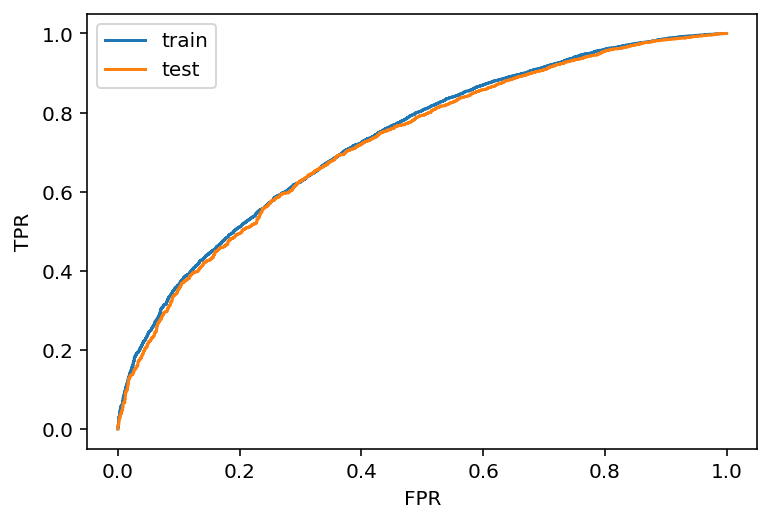

In [99]:
y_pred_lin_test = clf_lr.predict_proba(X_test_lin)[:, 1]
y_pred_lin_train = clf_lr.predict_proba(X_train_lin)[:, 1]

print('Train')
calc_auc(y_train, y_pred_lin_train, 'train')
print('Test')
calc_auc(y_test, y_pred_lin_test, 'test')
plt.legend();

Будем строить линейную комбинацию вида

$y=\alpha y + (1 - \alpha)y_2$

Параметр $\alpha$ переберем по сетке от 0 до 1, оценивая качество на тестовой выборке

In [103]:
np.linspace(0, 1, 100)

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

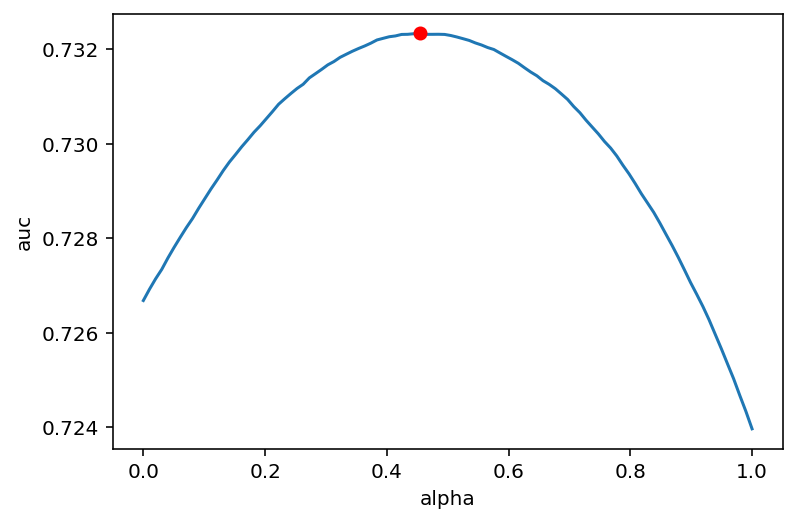

In [102]:
aucs = []
alpha_space = np.linspace(0, 1, 100)
for alpha in alpha_space:
    y_pred_weight = alpha * y_pred_lin_test + (1 - alpha) * y_pred_rf_test
    aucs.append(calc_auc(y_test, y_pred_weight, prin=False))

aucs = np.array(aucs)

max_ind = np.where(aucs == aucs.max())[0]
alpha = alpha_space[max_ind]

plt.plot(alpha_space, aucs)
plt.plot(alpha_space[max_ind], aucs[max_ind], 'o', c='r')
plt.xlabel('alpha')
plt.ylabel('auc')

# Итоговое взвешенное предсказание
y_pred_weight = alpha * y_pred_lin_test * (1 - alpha) * y_pred_rf_test

Сравним 3 метода (приблизим график ROC кривой, чтобы увидеть разницу)

Weighted:
ROC AUC: 0.7324
Log regression:
ROC AUC: 0.7240
Random forest:
ROC AUC: 0.7267


(0.5, 0.8)

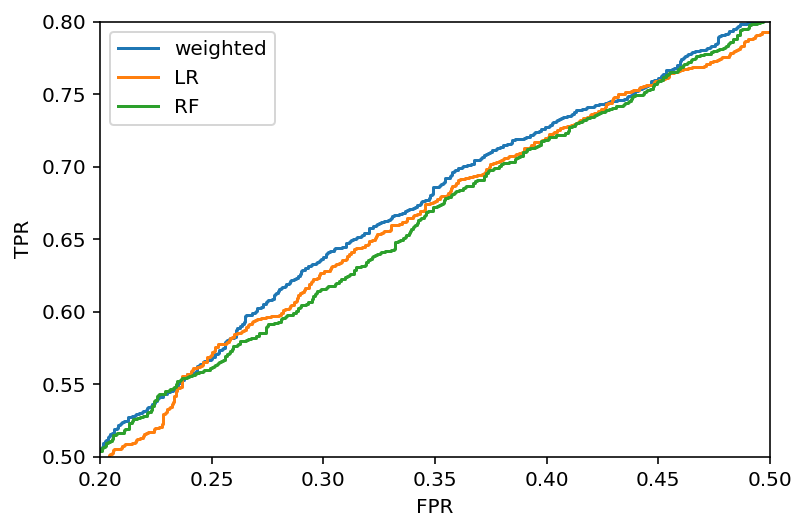

In [104]:
print('Weighted:')
calc_auc(y_test, y_pred_weight, 'weighted')
print('Log regression:')
calc_auc(y_test, y_pred_lin_test, 'LR')
print('Random forest:')
calc_auc(y_test, y_pred_rf_test, 'RF')
plt.legend();
plt.xlim(.2, .5)
plt.ylim(.5, .8)

### Стэкинг

#### Среднее значение таргета

Создадим новые признаки, на основе категориальных переменных. Каждому уникальному знаению $V$ переменной $X_i$
сопоставим среднее значение тергета среди всех объектов, у которых переменная $X_i$ принимает значение $V$

Новый признак со средним значением таргета в категории можно считать за предсказание вероятности красса 1
простого классификатора "усреднения"

Опишем класс этого классификатора

In [119]:
class MeanClassifier():
    
    def __init__(self, col):
        self._col = col
        
    
    
    def fit(self, X, y):
        self._y_mean = y.mean()
        self._means = y.groupby(X[self._col].astype(str)).mean()
        
    
    def predict_proba(self, X):
        new_feature = X[self._col].astype(str).map(self._means.to_dict()).fillna(self._y_mean)
        return np.stack([1-new_feature, new_feature], axis=1)
        

Делаем предсказание по фолдам кросс-валидации. **Главное не допустить утечки информации!** <br>
Опишем цункцию для стекинга.

In [117]:
def get_meta_features(clf, X_train, y_train, X_test, stack_cv):

    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = clf.predict_proba(X_train.iloc[test_ind])[:, 1]
        meta_test += clf.predict_proba(X_test)[:, 1]
    
    return meta_train, meta_test / stack_cv.n_splits

#### Стэкинг нескольких моделей

0. Средние значения
1. Random Forest
2. Log reg
3. SVM

Посмотрим, какое качество дает линейный SVM

для совместимости с общим кодом стекинга немного модифицируем класс SVM

Train
ROC AUC: 0.7311
Test
ROC AUC: 0.7214


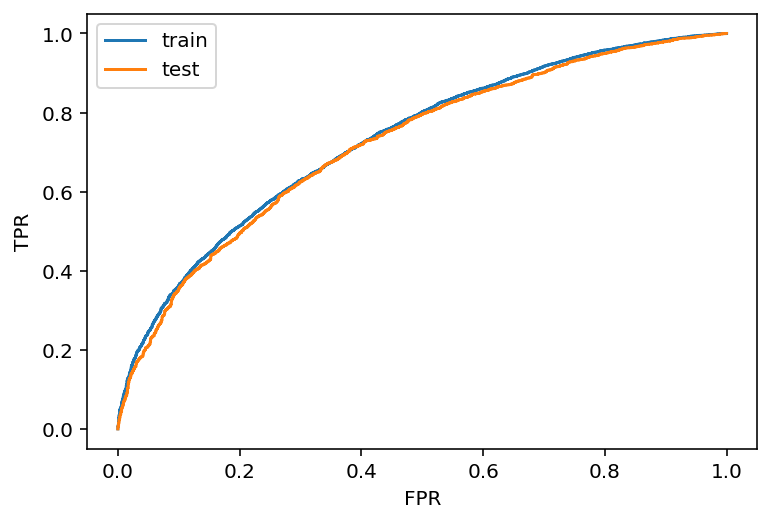

In [108]:
from sklearn.svm import LinearSVC

def norm(x):
    return (x - x.min()) / (x.max() - x.min())

class SVMWrapper(LinearSVC):
    
    def predict_proba(self, X):
        df = norm(self.decision_function(X))
        return np.stack([1-df, df], axis=1)


clf_svm = SVMWrapper(C=.001)
clf_svm.fit(X_train_lin, y_train)


y_pred_svm_test = clf_svm.predict_proba(X_test_lin)[:, 1]
y_pred_svm_train = clf_svm.predict_proba(X_train_lin)[:, 1]

print('Train')
calc_auc(y_train, y_pred_svm_train, 'train')
print('Test')
calc_auc(y_test, y_pred_svm_test, 'test')
plt.legend();

Теперь получим мета признаки для 3х моделей:
* SVM
* Logreg
* Random Forest
и средних значений по каждой категориальной переменной

In [121]:
from sklearn.model_selection import StratifiedKFold

stack_cv = StratifiedKFold(n_splits=10, random_state=555, shuffle=True)

meta_train = []
meta_test = []
col_names = []

print('mean futures...')
for c in cat_nunique.index.tolist():
    clf = MeanClassifier(c)
    
    meta_tr, meta_te = get_meta_features(clf, d_train, y_train, d_test, stack_cv)
    
    meta_train.append(meta_tr)
    meta_test.append(meta_te)
    col_names.append(f'mean_pred_{c}')
    
print('SVM futures...')
meta_tr, meta_te = get_meta_features(clf_svm, X_train_lin, y_train, X_test_lin, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('svm_pred')

print('LR futures...')
meta_tr, meta_te = get_meta_features(clf_lr, X_train_lin, y_train, X_test_lin, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('lr_pred')

print('RF features...')
meta_tr, meta_te = get_meta_features(clf_rf, X_train, y_train, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rf_pred')

mean futures...
SVM futures...
LR futures...
RF features...


In [122]:
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

#### Стэкинг мета-признаков с помощью LR

Используем регуляризованную лог регрессию в качестве алгоритма второго уровня

In [125]:
clf_lr_meta = LogisticRegression(penalty='l2', C=1, max_iter=200)

clf_lr_meta.fit(X_meta_train, y_train)

LogisticRegression(C=1, max_iter=200)

ROC AUC: 0.7358


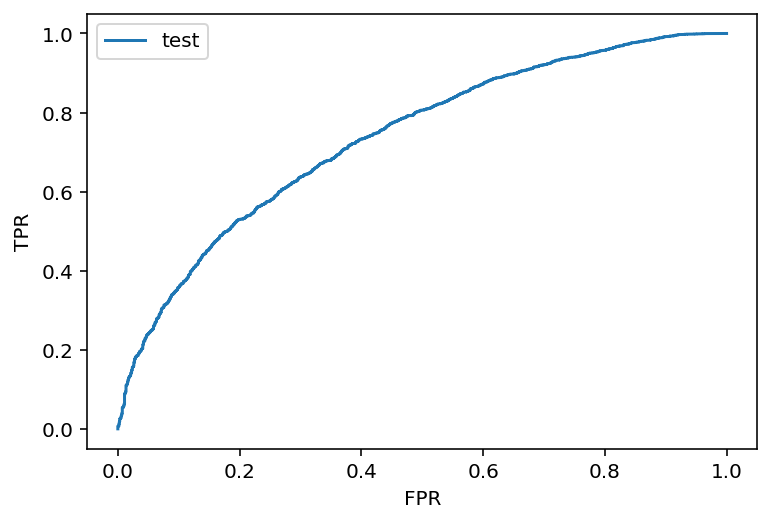

In [126]:
y_pred_meta_test = clf_lr_meta.predict_proba(X_meta_test)[:, 1]

calc_auc(y_test, y_pred_meta_test, 'test')
plt.legend();

#### Посмотрим на коэффициенты объединяющей линейной модели

Получим интерпретацию общей модели

<AxesSubplot:>

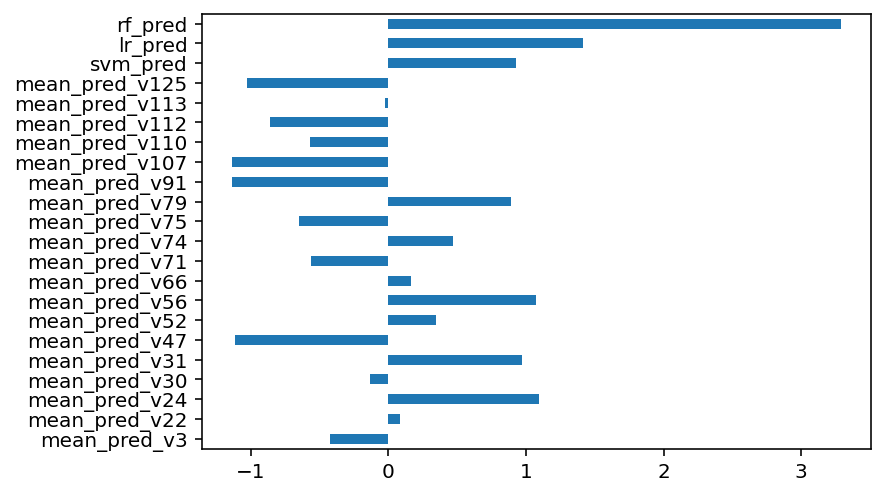

In [127]:
pd.Series(clf_lr_meta.coef_.flatten(), index=X_meta_train.columns).plot(kind='barh')

# Домашняя работа

#### Простая
1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
3. Построить случайный лес, вывести важность признаков
4. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
5. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
7. В качестве решения:
    Jupyter notebook с кодом, комментариями и графиками

#### Средняя
0. Все то же, что и в части 1, плюс:
1. Попробовать другие оценки важности переменных, например Boruta
http://danielhomola.com/2015/05/08/borutapy-an-all-relevant-feature-selection-method/#comments
3. Изучить extremely randomized trees (ExtraTreesRegressor в sklearn), сравнить с Random Forest
4. Проводить настройку гиперпараметров для моделей первого уровня в стекинге (перебирать руками и смотреть на CV или по сетке: GridSearchCV, RandomizedSearchCV)
5. Попробовать другие алгоритмы второго уровня
6. Сделать сабмиты на kaggle (минимум 3: отдельные модели vs стекинг), сравнить качество на локальной валидации и на leaderboard
7. В качестве решения:
    * Jupyter notebook с кодом, комментариями и графиками
    * сабмит на kaggle (ник на leaderboard)